Loading packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as mp
from IPython import display
import time

Reading in training and testing data

In [0]:
X_train = pd.read_csv('drive/My Drive/Data/X_train.csv',header=None).values
Y_train = pd.read_csv('drive/My Drive/Data/Y_train.csv',header=None).values

X_test = pd.read_csv('drive/My Drive/Data/X_test.csv',header=None).values
Y_test = pd.read_csv('drive/My Drive/Data/Y_test.csv',header=None).values

X_train = X_train[np.newaxis].T
Y_train = Y_train.T

X_test = X_test[np.newaxis].T
Y_test = Y_test.T

Normalizing (roughly)

In [0]:
X_train = (X_train-300*np.where(X_train == 0.0,0.0,1.0))/300
Y_train = (Y_train-300*np.where(Y_train == 0.0,0.0,1.0))/300
X_test = (X_test-300*np.where(X_test == 0.0,0.0,1.0))/300
Y_test = (Y_test-300*np.where(Y_test == 0.0,0.0,1.0))/300

Get/set parameters

In [0]:
n_in = X_train.shape[1]
n_out = Y_train.shape[1]
batch_size = X_train.shape[0]
H = 5
LSTM = "CudnnLSTM"
n_layers = 10
regularizer_rate = 0.01
learning_rate = 1e-2
epochs = 5000
target_loss = 7e-3

## Set up tensorflow graph

In [6]:
with tf.device("/device:GPU:0"):
    x = tf.placeholder(tf.float32, [None, n_in, 1])
    y = tf.placeholder(tf.float32, [None, n_out])
    mask = tf.placeholder(tf.float32, [None, n_out])
    
    inputs = tf.transpose(x, [1, 0, 2])
    
    weights = {
        'w1': tf.Variable(tf.random_normal([H, n_out],stddev=0.1,dtype=tf.float32))
    }

    biases = {
        'b1': tf.Variable(tf.random_normal([n_out],stddev=0.1,dtype=tf.float32))
    }
    
    if LSTM == "LSTMCell":
        ### CPU/GPU based LSTM Cell to layer
        lstm_cells = [tf.contrib.rnn.LSTMCell(H, forget_bias=1.0) for _ in range(n_layers)]
        stacked_lstm = tf.contrib.rnn.MultiRNNCell(lstm_cells)
        outputs, states = tf.nn.dynamic_rnn(stacked_lstm, inputs=inputs, dtype=tf.float32, time_major=True)
        
    elif LSTM == "CudnnLSTM":
        ### CUDA optimized LSTM layer
        lstm = tf.contrib.cudnn_rnn.CudnnLSTM(
              num_layers=n_layers,
              num_units=H,
              direction='unidirectional',
              dtype=tf.float32)
        lstm.build(inputs.get_shape())
        outputs, output_states = lstm(inputs, training=True)
    
    pred = tf.nn.bias_add(tf.matmul(outputs[-1], weights['w1']), biases['b1'])
    pred = pred*mask
    
    individual_losses = tf.reduce_sum(tf.squared_difference(pred, y), reduction_indices=1)
    loss_op = tf.reduce_mean(individual_losses) + regularizer_rate*(tf.nn.l2_loss(weights["w1"]))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_op)

    init = tf.global_variables_initializer()

W0722 08:20:22.272339 140009926981504 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0722 08:20:22.275296 140009926981504 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/cudnn_rnn/python/layers/cudnn_rnn.py:342: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 08:20:22.276455 140009926981504 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScal

## Start interactive Tensorflow session

In [0]:
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))

## Run Tensorflow training loop

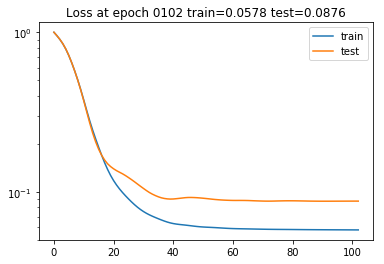

KeyboardInterrupt: ignored

In [8]:
sess.run(init)

start = time.time()

c_train_0 = sess.run(loss_op, feed_dict={x: X_train, y: Y_train, mask: np.where(Y_train == 0.0,0.0,1.0)})
c_test_0  = sess.run(loss_op, feed_dict={x: X_test,  y: Y_test,  mask: np.where(Y_test == 0.0,0.0,1.0)})

res_train = [1.0]
res_test = [1.0]

epoch = 0
c_train = c_train_0

#train_size = 128
#batches = int(batch_size/train_size)

while epoch < epochs and c_train/c_train_0 > target_loss:
    epoch = epoch+1
    
    #for i in range(batches):
    #    start_idx = i*train_size
    #    end_idx = (i+1)*train_size
    #    X_batch = X_train[start_idx:end_idx,:,:]
    #    Y_batch = Y_train[start_idx:end_idx,:]
    #    _ = sess.run(optimizer, feed_dict={x: X_batch, y: Y_batch, mask: np.where(Y_batch == 0.0,0.0,1.0)})
       
    _ = sess.run(optimizer, feed_dict={x: X_train, y: Y_train, mask: np.where(Y_train == 0.0,0.0,1.0)})
    c_train = sess.run(loss_op, feed_dict={x: X_train, y: Y_train, mask: np.where(Y_train == 0.0,0.0,1.0)})
    c_test  = sess.run(loss_op, feed_dict={x: X_test,  y: Y_test,  mask: np.where(Y_test == 0.0,0.0,1.0)})
    res_train.append(c_train/c_train_0)
    res_test.append(c_test/c_test_0)
    
    display.clear_output(wait=True)
    mp.figure()    
    #mp.clf()
    mp.semilogy(res_train,label="train")
    mp.semilogy(res_test,label="test")
    mp.legend()
    title = "Loss at epoch " + '%04d' % epoch + " train={:.4f}".format(c_train/c_train_0) + " test={:.4f}".format(c_test/c_test_0)
    mp.title(title)
    mp.show()
    #print(title)
end = time.time()
print("Training time: {:.4f}s".format(end-start))

## Visualize training fit

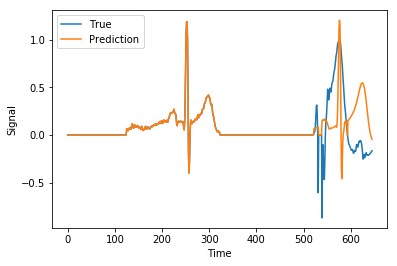

In [18]:
prediction = sess.run(pred, feed_dict={x: X_train, mask: np.where(Y_train==0.0,0.0,1.0)})
mp.plot(np.hstack((X_train[39,:,0],Y_train[39,:])).T,label="True")
mp.plot(np.hstack((X_train[39,:,0],prediction[39,:])).T,label="Prediction")
mp.xlabel("Time")
mp.ylabel("Signal")

mp.legend()

## Visualize test fit

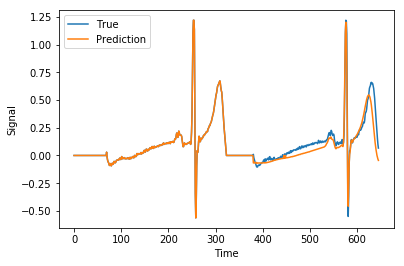

In [12]:
prediction = sess.run(pred, feed_dict={x: X_test, mask: np.where(Y_test==0.0,0.0,1.0)})
mp.plot(np.hstack((X_test[100,:,0],Y_test[100,:])).T,label="True")
mp.plot(np.hstack((X_test[100,:,0],prediction[100,:])).T,label="Prediction")
mp.xlabel("Time")
mp.ylabel("Signal")
mp.legend()